# 0. Setup

In [ ]:
!pip install vaderSentiment

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 2.8 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from textblob import TextBlob
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

import xgboost as xgb

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import warnings
warnings.filterwarnings('ignore')

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/spotify_data.csv')

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24369 entries, 0 to 24368
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   track_id          24369 non-null  object 
 1   track_name        24368 non-null  object 
 2   track_artist      24368 non-null  object 
 3   popular           24369 non-null  int64  
 4   release_year      24369 non-null  int64  
 5   release_month     24369 non-null  int64  
 6   playlist_genre    24369 non-null  object 
 7   danceability      24369 non-null  float64
 8   energy            24369 non-null  float64
 9   key               24369 non-null  int64  
 10  loudness          24369 non-null  float64
 11  mode              24369 non-null  int64  
 12  speechiness       24369 non-null  float64
 13  acousticness      24369 non-null  float64
 14  instrumentalness  24369 non-null  float64
 15  liveness          24369 non-null  float64
 16  valence           24369 non-null  float6

In [ ]:
# Check null values
df.isnull().sum()

,0
track_id,0
track_name,1
track_artist,1
popular,0
release_year,0
release_month,0
playlist_genre,0
danceability,0
energy,0
key,0


# 1. Data Preprocessing

## 1.1 Missing Data Imputation

In [ ]:
df.fillna('Unknown', inplace = True)

## 1.2 Creating Dummy Variables

In [ ]:
playlist_genre_dummies = pd.get_dummies(df['playlist_genre'], prefix='genre', drop_first=True)
key_mode_dummies = pd.get_dummies(df['key_mode'], prefix='key_mode', drop_first=True)
df = pd.concat([df, playlist_genre_dummies, key_mode_dummies], axis=1)

## 1.3 Creating Sentiment Variable

In [ ]:
def get_sentiment_vader(track_name):
  analyzer = SentimentIntensityAnalyzer()
  sentiment = analyzer.polarity_scores(track_name)
  return sentiment['compound']

# Example usage: Assuming your dataframe is named 'df' and has a 'track_name' column
df['track_sentiment_score_vader'] = df['track_name'].apply(get_sentiment_vader)

In [ ]:
print(df[['track_name', 'track_sentiment_score_vader']])

                          track_name  track_sentiment_score_vader
0                         I Miss You                      -0.1531
1                        Who Are You                       0.0000
2                              Happy                       0.5719
3                                ONE                       0.0000
4                       Palace/Curse                       0.0000
...                              ...                          ...
24364                          Tokyo                       0.0000
24365                  Drunken Truth                       0.3182
24366  Never Be Like You (feat. Kai)                      -0.2755
24367        Symphony - Original Mix                       0.3182
24368          Welcome To The Jungle                       0.4588

[24369 rows x 2 columns]


In [ ]:
df['track_sentiment_score_vader'].describe()

,track_sentiment_score_vader
count,24369.000000
mean,0.035505
std,0.245481
min,-0.897900
25%,0.000000
50%,0.000000
75%,0.000000
max,0.918600


In [ ]:
df[['track_name', 'track_sentiment_score_vader']].head(20)

,track_name,track_sentiment_score_vader
0,I Miss You,-0.1531
1,Who Are You,0.0000
2,Happy,0.5719
3,ONE,0.0000
4,Palace/Curse,0.0000
5,Hände hoch,0.0000
6,I'll Be Around - Remastered Version,0.0000
7,Música,0.0000
8,Trippie Redd,0.0000
9,Close Enough to Hurt,-0.5267


In [ ]:
# def get_sentiment_textblob(track_name):
#   analysis = TextBlob(track_name)
#   return analysis.sentiment.polarity

# # Example usage: Assuming your dataframe is named 'df' and has a 'track_name' column
# df['track_sentiment_score_textblob'] = df['track_name'].apply(get_sentiment_textblob)


In [ ]:
# print(df[['track_name', 'track_sentiment_score_textblob']])

In [ ]:
# df['track_sentiment_score_textblob'].describe()

In [ ]:
# df[['track_name', 'track_sentiment_score_textblob']].head(20)

In [ ]:
# df['track_sentiment_score_vader'].plot(kind = 'hist')

In [ ]:
# df['track_sentiment_score_textblob'].plot(kind = 'hist')

## 1.4 Merging Songs with Multiple Genres

In [ ]:
# Find songs with multiple genres
duplicate_track_ids = df[df.duplicated(subset=['track_id'], keep=False)]

print(duplicate_track_ids[['track_id']])

                     track_id
13     0IkKz2J93C94Ei4BvDop7P
31     35FIDQv0u26DSknDahmcdz
39     7BKLCZ1jbUBVqRi2FVlTVw
41     6qsArsTq6WoqtUFUe1e15W
43     4iLqG9SeJSnt0cSPICSjxv
...                       ...
24322  5ln5yQdUywVbf8HhFsOcd6
24338  164C9bSF4ryqWXI4XgxTE0
24340  2jt1zmAB5VEY9TLNNiXLKW
24343  1mzARUs2kMMxcKh1ome5aX
24366  47zREtxQZ3cHHIZwUQnuuN

[2620 rows x 1 columns]


In [ ]:
grouped = df.groupby('track_id')

In [ ]:
genre_cols = [col for col in df.columns if col.startswith('genre_')]

In [ ]:
combined_genre = grouped[genre_cols].any()

In [ ]:
df.drop(genre_cols, inplace = True, axis = 1)

In [ ]:
df = df.drop_duplicates(subset=['track_id'], keep='first')

In [ ]:
merged_df = pd.merge(df, combined_genre, on='track_id', how='inner')

In [ ]:
merged_df

,track_id,track_name,track_artist,popular,release_year,release_month,playlist_genre,danceability,energy,key,...,key_mode_8_0,key_mode_8_1,key_mode_9_0,key_mode_9_1,track_sentiment_score_vader,genre_latin,genre_pop,genre_r&b,genre_rap,genre_rock
0,697MjF1454XKvZmTuqkWmD,I Miss You,Jeriqo,0,2019,2,edm,0.520,0.789,0,...,False,False,False,False,-0.1531,False,False,False,False,False
1,3x2bXiU0o4WbsPkawXlfDA,Who Are You,The Who,0,1978,8,rock,0.651,0.661,9,...,False,False,False,True,0.0000,False,False,False,False,True
2,0jEaPBjFAWjQTMVouRwaHi,Happy,The Beef Seeds,0,2015,1,r&b,0.640,0.758,10,...,False,False,False,False,0.5719,False,False,True,False,False
3,5EKUb1FKsyYVaSXb41YBIj,ONE,Rev Theory,0,2020,1,rock,0.398,0.966,4,...,False,False,False,False,0.0000,False,False,False,False,True
4,300DUx4tdtCdGEUXR032jA,Palace/Curse,The Internet,0,2015,6,r&b,0.447,0.625,10,...,False,False,False,False,0.0000,False,False,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22939,4sdIuwRDXVZEKhs8ZY897a,"Happy Holidays, Parts 1 & 2",Ohio Players,0,1995,1,r&b,0.339,0.602,11,...,False,False,False,False,0.7430,False,False,True,False,False
22940,6bE9Ud8C8stzPwu7xJRx9u,Tokyo,Drevm,0,2019,12,rap,0.715,0.349,0,...,False,False,False,False,0.0000,False,False,False,True,False
22941,29ikXeGM6kScvhvqfvgiwO,Drunken Truth,Steve Void,0,2019,12,pop,0.781,0.745,1,...,False,False,False,False,0.3182,False,True,False,False,False
22942,61swngFBghaxXM0YT7CDU1,Symphony - Original Mix,Sandro Silva,0,2014,8,edm,0.545,0.774,0,...,False,False,False,False,0.3182,False,False,False,False,False


In [ ]:
merged_df.to_csv('Spotify_data_no_duplicate.csv', index=False)

# 2. Function Definition

In [ ]:
def prediction_evaluation(model, X, y, cut_offs=[0.15, 0.25, 0.3, 0.5]):
    """
    Function to evaluate classification model performance using custom cutoffs.
    Works for both scikit-learn and statsmodels models.

    Parameters:
    model: The classification model (either statsmodels or scikit-learn)
    X: The feature set
    y: The true target labels
    cut_offs: List of thresholds to evaluate model performance

    Returns:
    Displays a DataFrame with evaluation metrics at each cutoff.
    """

    # Check if the model has `predict_proba` (scikit-learn models) or just `predict` (statsmodels)
    if hasattr(model, 'predict_proba'):
        # For scikit-learn models
        y_prob = model.predict_proba(X)[:, 1]  # Get probabilities for class 1
    else:
        # For statsmodels models
        y_prob = model.predict(X)  # Statsmodels returns probabilities directly via predict()

    # Define sample size
    sample_size = len(y)

    # AUC-ROC is threshold-independent
    auc = roc_auc_score(y, y_prob)

    # Initialize evaluation results
    evaluation = []

    # Evaluation based on custom cutoffs
    for cutoff in cut_offs:
        # Generate predictions based on the cutoff threshold
        y_pred_custom = (y_prob >= cutoff).astype(int)

        # Get confusion matrix values
        tn, fp, fn, tp = confusion_matrix(y, y_pred_custom).ravel()

        # Profit calculation based on the confusion matrix
        profit = 120000*tp - 10000 *fp

        # Append evaluation results for this cutoff
        evaluation.append({
            'Cutoff': cutoff,
            'Accuracy': accuracy_score(y, y_pred_custom),
            'Precision': precision_score(y, y_pred_custom),
            'Recall': recall_score(y, y_pred_custom),
            'AUC_ROC': auc,
            'Confusion Matrix': confusion_matrix(y, y_pred_custom),
            'Profit': profit
        })

    # Convert results to DataFrame
    evaluation_df = pd.DataFrame(evaluation)

    return evaluation_df

In [ ]:
def prediction_evaluation_late_popular(model, X, y, cut_offs=[0.15, 0.25, 0.3, 0.5]):
    """
    Function to evaluate classification model performance using custom cutoffs.
    Works for both scikit-learn and statsmodels models.

    Parameters:
    model: The classification model (either statsmodels or scikit-learn)
    X: The feature set
    y: The true target labels
    cut_offs: List of thresholds to evaluate model performance

    Returns:
    Displays a DataFrame with evaluation metrics at each cutoff.
    """

    # Check if the model has `predict_proba` (scikit-learn models) or just `predict` (statsmodels)
    if hasattr(model, 'predict_proba'):
        # For scikit-learn models
        y_prob = model.predict_proba(X)[:, 1]  # Get probabilities for class 1
    else:
        # For statsmodels models
        y_prob = model.predict(X)  # Statsmodels returns probabilities directly via predict()

    # Define sample size
    sample_size = len(y)

    # AUC-ROC is threshold-independent
    auc = roc_auc_score(y, y_prob)

    # Initialize evaluation results
    evaluation = []

    # Evaluation based on custom cutoffs
    for cutoff in cut_offs:
        # Generate predictions based on the cutoff threshold
        y_pred_custom = (y_prob >= cutoff).astype(int)

        # Get confusion matrix values
        tn, fp, fn, tp = confusion_matrix(y, y_pred_custom).ravel()

        # Profit calculation based on the confusion matrix
        profit = 120000*tp + 16000*fp

        # Append evaluation results for this cutoff
        evaluation.append({
            'Cutoff': cutoff,
            'Accuracy': accuracy_score(y, y_pred_custom),
            'Precision': precision_score(y, y_pred_custom),
            'Recall': recall_score(y, y_pred_custom),
            'AUC_ROC': auc,
            'Confusion Matrix': confusion_matrix(y, y_pred_custom),
            'Profit': profit
        })

    # Convert results to DataFrame
    evaluation_df = pd.DataFrame(evaluation)

    return evaluation_df

In [ ]:
def make_confusion_matrix(model, cutoff=0.15, X_tr=None, X_ts=None, y_tr=None, y_ts=None):
    """
    Function to create confusion matrices for training and testing datasets.
    Works with both statsmodels and scikit-learn models.

    Parameters:
    model: The trained classification model (either statsmodels or scikit-learn)
    cutoff: The threshold for classifying probabilities as class 1
    X_tr: Training feature set
    X_ts: Testing feature set
    y_tr: Training true labels
    y_ts: Testing true labels
    """

    # Helper function to get predicted probabilities
    def get_probabilities(model, X):
        # Check if the model has a `predict_proba` method (scikit-learn models) or `predict` for statsmodels
        if hasattr(model, 'predict_proba'):
            # For scikit-learn models that provide probabilities
            return model.predict_proba(X)[:, 1]  # Get probabilities for class 1
        else:
            # For statsmodels models
            return model.predict(X)  # Statsmodels returns probabilities directly via predict()

    # For Training Data
    y_prob_train = get_probabilities(model, X_tr)
    y_pred_train_custom = (y_prob_train >= cutoff).astype(int)
    confusion_train = confusion_matrix(y_tr, y_pred_train_custom)

    group_counts_train = ["{0:0.0f}".format(value) for value in confusion_train.flatten()]
    group_percentages_train = ["{0:.2%}".format(value) for value in confusion_train.flatten()/np.sum(confusion_train)]
    labels_train = [f"{v1}\n{v2}" for v1, v2 in zip(group_counts_train, group_percentages_train)]
    labels_train = np.asarray(labels_train).reshape(2, 2)

    # For Testing Data
    y_prob_test = get_probabilities(model, X_ts)
    y_pred_test_custom = (y_prob_test >= cutoff).astype(int)
    confusion_test = confusion_matrix(y_ts, y_pred_test_custom)

    group_counts_test = ["{0:0.0f}".format(value) for value in confusion_test.flatten()]
    group_percentages_test = ["{0:.2%}".format(value) for value in confusion_test.flatten()/np.sum(confusion_test)]
    labels_test = [f"{v1}\n{v2}" for v1, v2 in zip(group_counts_test, group_percentages_test)]
    labels_test = np.asarray(labels_test).reshape(2, 2)

    # Display confusion matrices
    print("Confusion Matrix for Training Data:")
    print(confusion_train)

    print("\nConfusion Matrix for Testing Data:")
    print(confusion_test)

    # Plot confusion matrices
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))

    sns.heatmap(confusion_train, annot=labels_train, fmt='', cmap='Blues', ax=ax[0])
    ax[0].set_title('Training Confusion Matrix')
    ax[0].set_xlabel('Predicted')
    ax[0].set_ylabel('Actual')

    sns.heatmap(confusion_test, annot=labels_test, fmt='', cmap='Blues', ax=ax[1])
    ax[1].set_title('Testing Confusion Matrix')
    ax[1].set_xlabel('Predicted')
    ax[1].set_ylabel('Actual')

    plt.tight_layout()
    plt.show()


In [ ]:
X = merged_df[['danceability', 'energy',
       'loudness', 'speechiness', 'acousticness', 'instrumentalness',
       'liveness', 'valence', 'tempo',
       'key_mode_0_1', 'key_mode_10_0', 'key_mode_10_1', 'key_mode_11_0',
       'key_mode_11_1', 'key_mode_1_0', 'key_mode_1_1', 'key_mode_2_0',
       'key_mode_2_1', 'key_mode_3_0', 'key_mode_3_1', 'key_mode_4_0',
       'key_mode_4_1', 'key_mode_5_0', 'key_mode_5_1', 'key_mode_6_0',
       'key_mode_6_1', 'key_mode_7_0', 'key_mode_7_1', 'key_mode_8_0',
       'key_mode_8_1', 'key_mode_9_0', 'key_mode_9_1',
       'track_sentiment_score_vader', 'genre_latin', 'genre_pop', 'genre_r&b',
       'genre_rap', 'genre_rock']]
y = merged_df['popular']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=528)

# 3. Model Training

## 3.1 Logistc Regression

In [ ]:
log_reg = LogisticRegression(penalty=None)

In [ ]:
log_reg.fit(X_train, y_train)

LogisticRegression(penalty=None)

In [ ]:
log_reg.score(X_test, y_test)

0.8387565368971528

In [ ]:
logreg_eval_df = prediction_evaluation(log_reg, X_test, y_test, cut_offs=np.arange(0, 0.2, 0.01))
logreg_eval_df

,Cutoff,Accuracy,Precision,Recall,AUC_ROC,Confusion Matrix,Profit
0,0.00,0.169814,0.169814,1.000000,0.719344,"[[0, 5715], [0, 1169]]",83130000
1,0.01,0.214555,0.176883,0.992301,0.719344,"[[317, 5398], [9, 1160]]",85220000
2,0.02,0.244335,0.181990,0.987169,0.719344,"[[528, 5187], [15, 1154]]",86610000
3,0.03,0.286752,0.189027,0.972626,0.719344,"[[837, 4878], [32, 1137]]",87660000
4,0.04,0.329169,0.195802,0.949530,0.719344,"[[1156, 4559], [59, 1110]]",87610000
5,0.05,0.359529,0.200997,0.931565,0.719344,"[[1386, 4329], [80, 1089]]",87390000
6,0.06,0.378850,0.205162,0.924722,0.719344,"[[1527, 4188], [88, 1081]]",87840000
7,0.07,0.397008,0.209016,0.916168,0.719344,"[[1662, 4053], [98, 1071]]",87990000
8,0.08,0.414875,0.212663,0.905047,0.719344,"[[1798, 3917], [111, 1058]]",87790000
9,0.09,0.434631,0.216767,0.891360,0.719344,"[[1950, 3765], [127, 1042]]",87390000


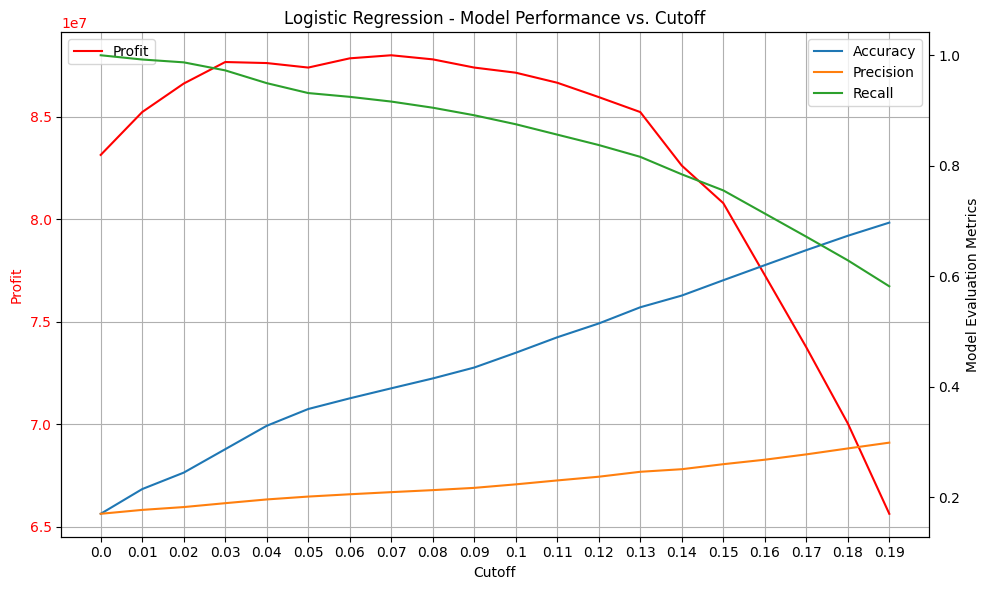

In [ ]:
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot the first field
ax1.plot(logreg_eval_df['Cutoff'], logreg_eval_df['Profit'], label='Profit', color='r')
ax1.set_xlabel('Cutoff')
ax1.set_ylabel('Profit', color='r')
ax1.tick_params(axis='y', labelcolor='r')
ax1.grid(True)

# Create a twin y-axis for the second field
ax2 = ax1.twinx()
ax2.plot(logreg_eval_df['Cutoff'], logreg_eval_df['Accuracy'], label='Accuracy')
ax2.plot(logreg_eval_df['Cutoff'], logreg_eval_df['Precision'], label='Precision')
ax2.plot(logreg_eval_df['Cutoff'], logreg_eval_df['Recall'], label='Recall')
ax2.set_ylabel('Model Evaluation Metrics')
ax2.tick_params(axis='y')

plt.xticks(ticks=logreg_eval_df['Cutoff'], labels=logreg_eval_df['Cutoff'], rotation=45)  # Rotate labels for better visibility if needed

# Add a title
plt.title('Logistic Regression - Model Performance vs. Cutoff')

# Add legends for both axes
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

plt.tight_layout()
plt.show()


Confusion Matrix for Training Data:
[[3835 9618]
 [ 161 2446]]

Confusion Matrix for Testing Data:
[[1662 4053]
 [  98 1071]]


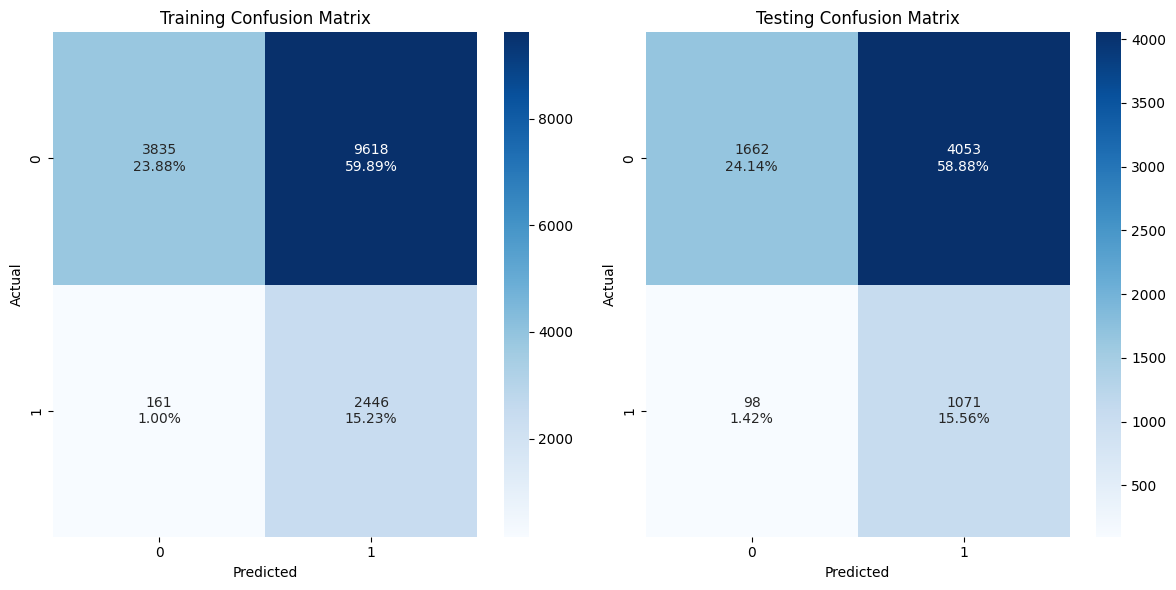

In [ ]:
make_confusion_matrix(log_reg, cutoff = 0.07, X_tr=X_train, X_ts=X_test, y_tr=y_train, y_ts=y_test)

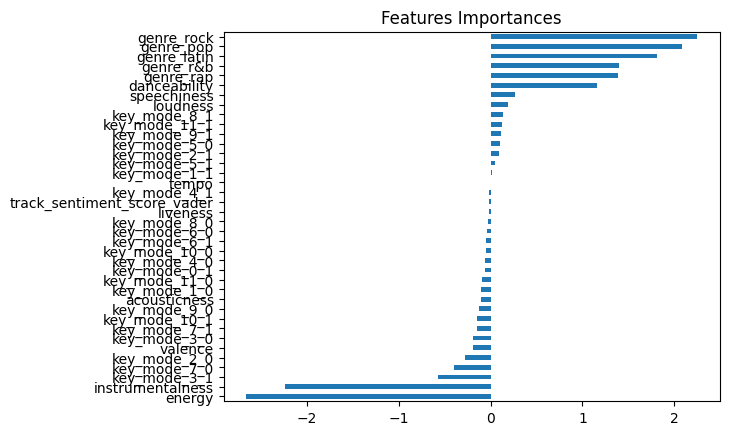

In [ ]:
importances_sorted = pd.Series(
    data=log_reg.coef_[0],  # Access the first class's coefficients (for binary classification)
    index=X.columns
).sort_values()

# Plot a horizontal barplot of importances_sorted
importances_sorted.plot(kind="barh")
plt.title("Features Importances")
plt.show()

In [ ]:
logreg_eval_df_late_pop = prediction_evaluation_late_popular(log_reg, X_test, y_test, cut_offs=np.arange(0, 0.2, 0.01))

## 3.2 Decision Tree

In [ ]:
#function for visualization of tree for interpretation
def show_tree(model, fea_names = X_train.columns):
  plt.figure(figsize=(20,30))
  tree.plot_tree(model,
                 filled=True,
                 feature_names= fea_names,
                 class_names=True,
                 fontsize=9,
                 node_ids=True)
  plt.show()

  # tree_rules = tree.export_text(model, feature_names=list(X_train.columns))
  # print(tree_rules)

In [ ]:
#function for examine the split
def visualize_split(model, X=X_train):
  feature_importances = pd.Series(model.feature_importances_, index=X.columns)
  feature_importances = feature_importances.sort_values(ascending=False)
  print(feature_importances)

  # Assuming 'feature_importances' is already calculated and sorted
  plt.figure(figsize=(10, 6))
  sns.barplot(x=feature_importances.values, y=feature_importances.index, palette='Blues_r')

  # Add labels and title
  plt.title('Feature Importances', fontsize=16)
  plt.xlabel('Importance Score', fontsize=12)
  plt.ylabel('Features', fontsize=12)

  # Display the plot
  plt.tight_layout()
  plt.show()


In [ ]:
tree_default = DecisionTreeClassifier(criterion="gini", random_state=528)
tree_default.fit(X_train, y_train)

DecisionTreeClassifier(random_state=528)

In [ ]:
prediction_evaluation(tree_default, X_test, y_test, cut_offs=np.arange(0, 1, 0.05))

,Cutoff,Accuracy,Precision,Recall,AUC_ROC,Confusion Matrix,Profit
0,0.00,0.169814,0.169814,1.000000,0.566706,"[[0, 5715], [0, 1169]]",83130000
1,0.05,0.752615,0.277500,0.284859,0.566706,"[[4848, 867], [836, 333]]",31290000
2,0.10,0.752615,0.277500,0.284859,0.566706,"[[4848, 867], [836, 333]]",31290000
3,0.15,0.752615,0.277500,0.284859,0.566706,"[[4848, 867], [836, 333]]",31290000
4,0.20,0.752615,0.277500,0.284859,0.566706,"[[4848, 867], [836, 333]]",31290000
5,0.25,0.752615,0.277500,0.284859,0.566706,"[[4848, 867], [836, 333]]",31290000
6,0.30,0.752615,0.277500,0.284859,0.566706,"[[4848, 867], [836, 333]]",31290000
7,0.35,0.752615,0.277500,0.284859,0.566706,"[[4848, 867], [836, 333]]",31290000
8,0.40,0.752615,0.277500,0.284859,0.566706,"[[4848, 867], [836, 333]]",31290000
9,0.45,0.752615,0.277500,0.284859,0.566706,"[[4848, 867], [836, 333]]",31290000


liveness                       0.091419
danceability                   0.091142
tempo                          0.088004
energy                         0.085788
valence                        0.085472
loudness                       0.084688
acousticness                   0.082660
speechiness                    0.079004
instrumentalness               0.072149
track_sentiment_score_vader    0.034046
genre_pop                      0.025843
genre_latin                    0.023310
genre_r&b                      0.018788
genre_rap                      0.017588
genre_rock                     0.013732
key_mode_6_0                   0.009852
key_mode_7_1                   0.007550
key_mode_9_1                   0.007357
key_mode_11_1                  0.006354
key_mode_1_0                   0.006074
key_mode_4_0                   0.005886
key_mode_5_0                   0.005819
key_mode_8_1                   0.005640
key_mode_5_1                   0.005519
key_mode_2_1                   0.005086


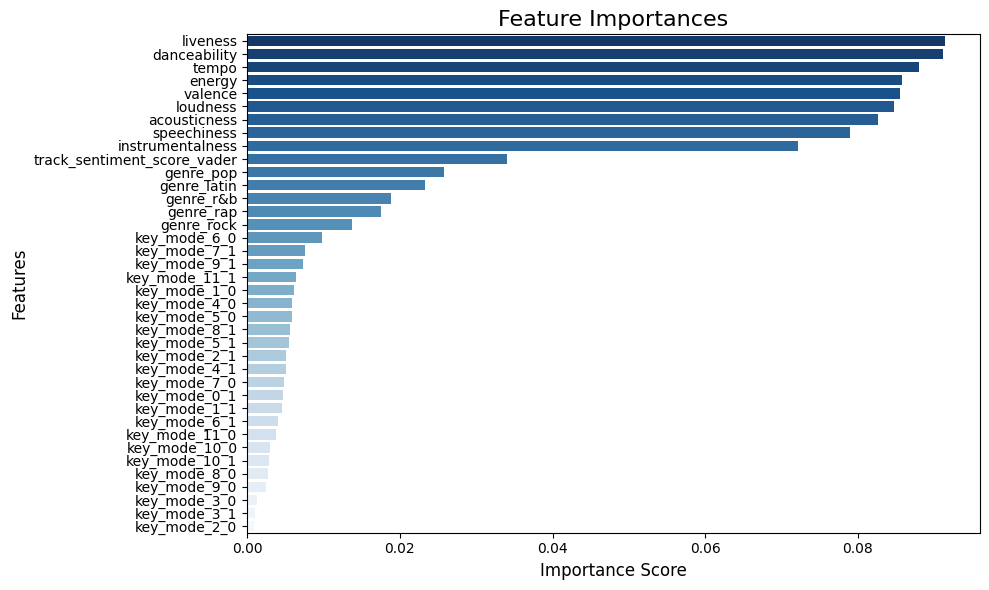

In [ ]:
visualize_split(tree_default)

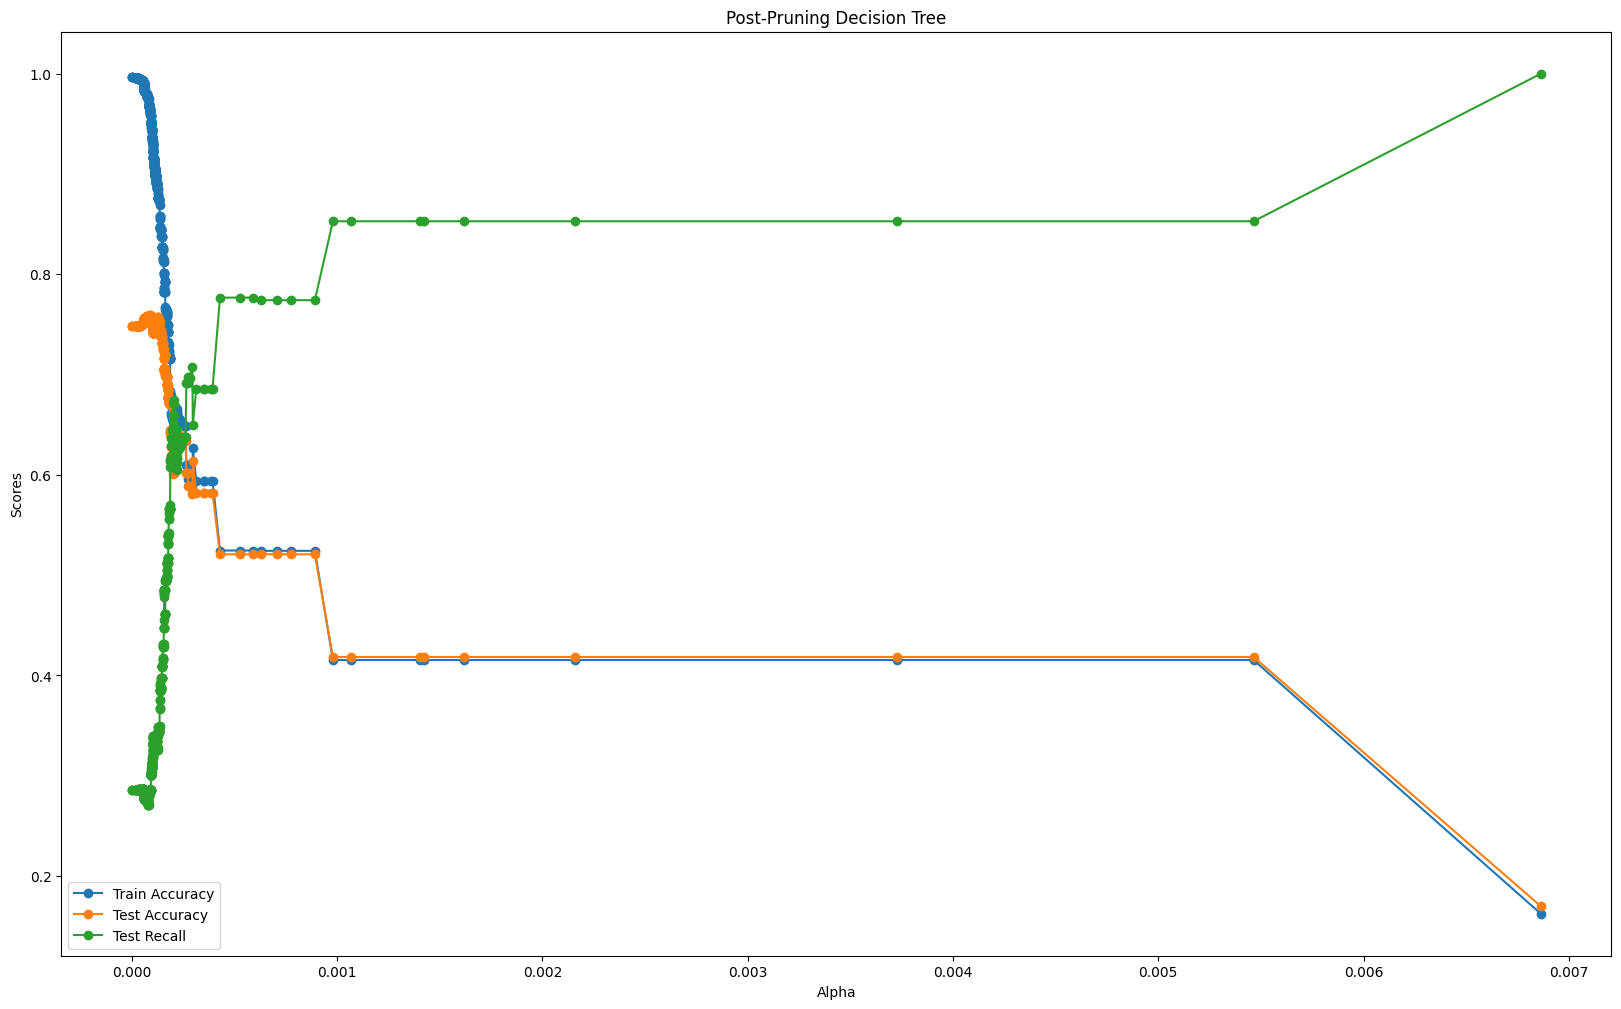

Optimal Alpha: 0.0068637242635568585
Accuracy on the test set: 0.8301859384079023


In [ ]:
clf = DecisionTreeClassifier(random_state=528)
path = clf.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas = path.ccp_alphas

# Initialize variables to store results
train_accuracy_scores = []
test_accuracy_scores = []
test_recall = []

# Iterate through the range of alpha values to prune the tree
for ccp_alpha in ccp_alphas:
    # Create a Decision Tree with the current alpha
    clf = DecisionTreeClassifier(random_state=42, ccp_alpha=ccp_alpha)
    clf.fit(X_train, y_train)

    y_train_pred_proba = clf.predict_proba(X_train)[:, 1]
    y_train_predict = (y_train_pred_proba >= 0.15).astype(int)
    y_test_pred_proba = clf.predict_proba(X_test)[:, 1]
    y_test_predict = (y_test_pred_proba >= 0.15).astype(int)

    # Calculate cross-validated accuracy on the training and testing sets
    train_accuracy_scores.append(accuracy_score(y_train, y_train_predict))
    test_accuracy_scores.append(accuracy_score(y_test, y_test_predict))
    test_recall.append(recall_score(y_test, y_test_predict))

# Plot the training and testing scores against alpha values
plt.figure(figsize=(20,12))
plt.plot(ccp_alphas, train_accuracy_scores, label='Train Accuracy', marker='o')
plt.plot(ccp_alphas, test_accuracy_scores, label='Test Accuracy', marker='o')
plt.plot(ccp_alphas, test_recall, label='Test Recall', marker='o')
plt.xlabel('Alpha')
plt.ylabel('Scores')
plt.title('Post-Pruning Decision Tree')
plt.legend()
plt.show()

# Find the alpha with the highest test score
optimal_alpha = ccp_alphas[np.argmax(test_recall)]
print(f'Optimal Alpha: {optimal_alpha}')

# Train the final model with the optimal alpha
pruned_tree = DecisionTreeClassifier(random_state=528, ccp_alpha=optimal_alpha)
pruned_tree.fit(X_train, y_train)
print(f'Accuracy on the test set: {pruned_tree.score(X_test, y_test)}')

In [ ]:
dt_eval_df = prediction_evaluation(pruned_tree, X_test, y_test, cut_offs=np.arange(0, 0.2, 0.01))

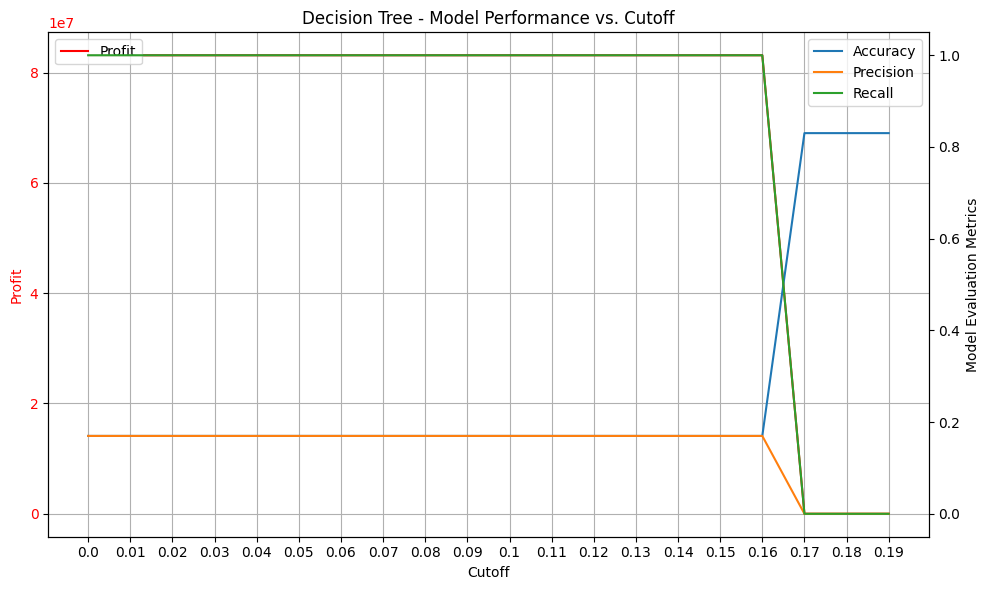

In [ ]:
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot the first field
ax1.plot(dt_eval_df['Cutoff'], dt_eval_df['Profit'], label='Profit', color='r')
ax1.set_xlabel('Cutoff')
ax1.set_ylabel('Profit', color='r')
ax1.tick_params(axis='y', labelcolor='r')
ax1.grid(True)

# Create a twin y-axis for the second field
ax2 = ax1.twinx()
ax2.plot(dt_eval_df['Cutoff'], dt_eval_df['Accuracy'], label='Accuracy')
ax2.plot(dt_eval_df['Cutoff'], dt_eval_df['Precision'], label='Precision')
ax2.plot(dt_eval_df['Cutoff'], dt_eval_df['Recall'], label='Recall')
ax2.set_ylabel('Model Evaluation Metrics')
ax2.tick_params(axis='y')

plt.xticks(ticks=dt_eval_df['Cutoff'], labels=dt_eval_df['Cutoff'], rotation=45)  # Rotate labels for better visibility if needed

# Add a title
plt.title('Decision Tree - Model Performance vs. Cutoff')

# Add legends for both axes
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

plt.tight_layout()
plt.show()

danceability                   0.0
key_mode_8_0                   0.0
key_mode_4_1                   0.0
key_mode_5_0                   0.0
key_mode_5_1                   0.0
key_mode_6_0                   0.0
key_mode_6_1                   0.0
key_mode_7_0                   0.0
key_mode_7_1                   0.0
key_mode_8_1                   0.0
energy                         0.0
key_mode_9_0                   0.0
key_mode_9_1                   0.0
track_sentiment_score_vader    0.0
genre_latin                    0.0
genre_pop                      0.0
genre_r&b                      0.0
genre_rap                      0.0
key_mode_4_0                   0.0
key_mode_3_1                   0.0
key_mode_3_0                   0.0
key_mode_2_1                   0.0
loudness                       0.0
speechiness                    0.0
acousticness                   0.0
instrumentalness               0.0
liveness                       0.0
valence                        0.0
tempo               

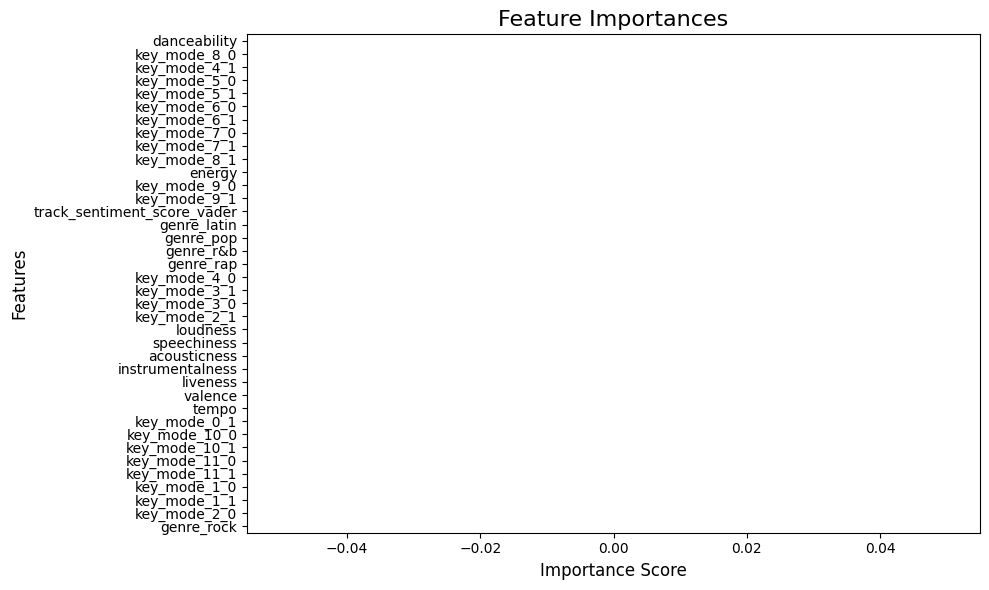

In [ ]:
visualize_split(pruned_tree)

## 3.3 Random Forest

In [ ]:
rf_classifier = RandomForestClassifier(random_state=528)
rf_classifier.fit(X_train, y_train)

RandomForestClassifier(random_state=528)

In [ ]:
prediction_evaluation(rf_classifier, X_test, y_test, cut_offs=np.arange(0, 0.2, 0.01))

,Cutoff,Accuracy,Precision,Recall,AUC_ROC,Confusion Matrix,Profit
0,0.00,0.169814,0.169814,1.000000,0.70615,"[[0, 5715], [0, 1169]]",83130000
1,0.01,0.189570,0.173140,0.999145,0.70615,"[[137, 5578], [1, 1168]]",84380000
2,0.02,0.213393,0.176766,0.993157,0.70615,"[[308, 5407], [8, 1161]]",85250000
3,0.03,0.243899,0.181703,0.985458,0.70615,"[[527, 5188], [17, 1152]]",86360000
4,0.04,0.275567,0.187152,0.976903,0.70615,"[[755, 4960], [27, 1142]]",87440000
5,0.05,0.302586,0.191156,0.961506,0.70615,"[[959, 4756], [45, 1124]]",87320000
6,0.06,0.330622,0.195933,0.947819,0.70615,"[[1168, 4547], [61, 1108]]",87490000
7,0.07,0.360401,0.200556,0.926433,0.70615,"[[1398, 4317], [86, 1083]]",86790000
8,0.08,0.389599,0.206162,0.910180,0.70615,"[[1618, 4097], [105, 1064]]",86710000
9,0.09,0.424172,0.213920,0.893926,0.70615,"[[1875, 3840], [124, 1045]]",87000000


In [ ]:
# Define the parameter grid for GridSearchCV
param_grid = {
    'n_estimators': [50, 100, 200],  # Number of trees in the forest
    'max_depth': [None, 10, 20],     # Maximum depth of each tree
    'min_samples_split': [2, 5, 10],  # Minimum samples required to split an internal node
    'min_samples_leaf': [1, 2, 4]     # Minimum samples required to be at a leaf node
}

# Create GridSearchCV object
grid_search = GridSearchCV(estimator=rf_classifier, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)

# Fit the GridSearchCV object to the training data
grid_search.fit(X_train, y_train)

# Get the best hyperparameters and the best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print(f"Best Hyperparameters: {best_params}")
print(f"Best Score (Accuracy): {best_score}")

# Evaluate the best model on the test set
best_rf_model = grid_search.best_estimator_
rf_eval_df = prediction_evaluation(best_rf_model, X_test, y_test, cut_offs=np.arange(0, 0.2, 0.01))

Best Hyperparameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Best Score (Accuracy): 0.17106505620093201


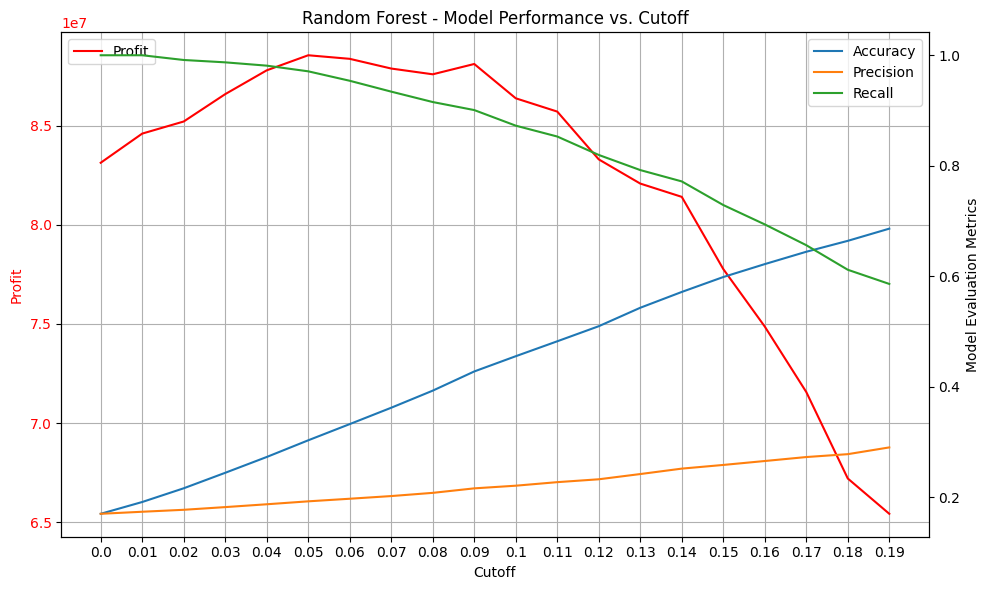

In [ ]:
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot the first field
ax1.plot(rf_eval_df['Cutoff'], rf_eval_df['Profit'], label='Profit', color='r')
ax1.set_xlabel('Cutoff')
ax1.set_ylabel('Profit', color='r')
ax1.tick_params(axis='y', labelcolor='r')
ax1.grid(True)

# Create a twin y-axis for the second field
ax2 = ax1.twinx()
ax2.plot(rf_eval_df['Cutoff'], rf_eval_df['Accuracy'], label='Accuracy')
ax2.plot(rf_eval_df['Cutoff'], rf_eval_df['Precision'], label='Precision')
ax2.plot(rf_eval_df['Cutoff'], rf_eval_df['Recall'], label='Recall')
ax2.set_ylabel('Model Evaluation Metrics')
ax2.tick_params(axis='y')

plt.xticks(ticks=rf_eval_df['Cutoff'], labels=rf_eval_df['Cutoff'], rotation=45)  # Rotate labels for better visibility if needed

# Add a title
plt.title('Random Forest - Model Performance vs. Cutoff')

# Add legends for both axes
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

plt.tight_layout()
plt.show()


## 3.4 Bagging

In [ ]:
bagging_classifier = BaggingClassifier(estimator=DecisionTreeClassifier(random_state=528), n_estimators=100, random_state=528)
bagging_classifier.fit(X_train, y_train)

BaggingClassifier(estimator=DecisionTreeClassifier(random_state=528),
                  n_estimators=100, random_state=528)

In [ ]:
prediction_evaluation(bagging_classifier, X_test, y_test, cut_offs=np.arange(0, 0.2, 0.01))

,Cutoff,Accuracy,Precision,Recall,AUC_ROC,Confusion Matrix,Profit
0,0.00,0.169814,0.169814,1.000000,0.696375,"[[0, 5715], [0, 1169]]",83130000
1,0.01,0.227775,0.178776,0.987169,0.696375,"[[414, 5301], [15, 1154]]",85470000
2,0.02,0.268884,0.186058,0.979470,0.696375,"[[706, 5009], [24, 1145]]",87310000
3,0.03,0.304474,0.191685,0.962361,0.696375,"[[971, 4744], [44, 1125]]",87560000
4,0.04,0.336142,0.197258,0.947819,0.696375,"[[1206, 4509], [61, 1108]]",87870000
5,0.05,0.362144,0.202768,0.940120,0.696375,"[[1394, 4321], [70, 1099]]",88670000
6,0.06,0.388437,0.207540,0.923011,0.696375,"[[1595, 4120], [90, 1079]]",88280000
7,0.07,0.414439,0.212072,0.901625,0.696375,"[[1799, 3916], [115, 1054]]",87320000
8,0.08,0.435067,0.214166,0.871685,0.696375,"[[1976, 3739], [150, 1019]]",84890000
9,0.09,0.461650,0.219048,0.846022,0.696375,"[[2189, 3526], [180, 989]]",83420000


In [ ]:
# Define the parameter grid for GridSearchCV
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_samples': [0.5, 0.8, 1.0],
    'max_features': [0.5, 0.8, 1.0]
}

# Create GridSearchCV object
grid_search_bagging = GridSearchCV(estimator=bagging_classifier, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)

# Fit the GridSearchCV object to the training data
grid_search_bagging.fit(X_train, y_train)

# Get the best hyperparameters and the best score
best_params_bagging = grid_search_bagging.best_params_
best_score_bagging = grid_search_bagging.best_score_

print(f"Best Hyperparameters for Bagging: {best_params_bagging}")
print(f"Best Score (Accuracy) for Bagging: {best_score_bagging}")

# Evaluate the best bagging model on the test set
best_bagging_model = grid_search_bagging.best_estimator_
bagging_eval_df = prediction_evaluation(best_bagging_model, X_test, y_test, cut_offs=np.arange(0, 0.2, 0.01))

Best Hyperparameters for Bagging: {'max_features': 1.0, 'max_samples': 1.0, 'n_estimators': 200}
Best Score (Accuracy) for Bagging: 0.23783046120423798


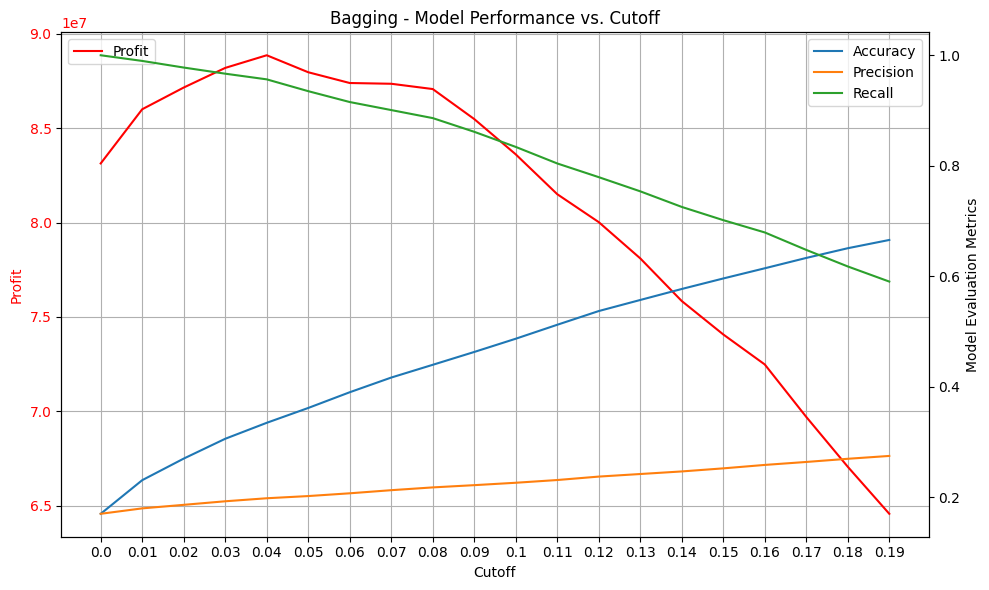

In [ ]:
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot the first field
ax1.plot(bagging_eval_df['Cutoff'], bagging_eval_df['Profit'], label='Profit', color='r')
ax1.set_xlabel('Cutoff')
ax1.set_ylabel('Profit', color='r')
ax1.tick_params(axis='y', labelcolor='r')
ax1.grid(True)

# Create a twin y-axis for the second field
ax2 = ax1.twinx()
ax2.plot(bagging_eval_df['Cutoff'], bagging_eval_df['Accuracy'], label='Accuracy')
ax2.plot(bagging_eval_df['Cutoff'], bagging_eval_df['Precision'], label='Precision')
ax2.plot(bagging_eval_df['Cutoff'], bagging_eval_df['Recall'], label='Recall')
ax2.set_ylabel('Model Evaluation Metrics')
ax2.tick_params(axis='y')

plt.xticks(ticks=bagging_eval_df['Cutoff'], labels=bagging_eval_df['Cutoff'], rotation=45)  # Rotate labels for better visibility if needed

# Add a title
plt.title('Bagging - Model Performance vs. Cutoff')

# Add legends for both axes
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

plt.tight_layout()
plt.show()


## 3.5 XGBoost

In [ ]:

# Initialize XGBoost classifier
xgb_classifier = xgb.XGBClassifier(random_state=528)

# Define the parameter grid for GridSearchCV
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.3],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

# Create GridSearchCV object
grid_search_xgb = GridSearchCV(estimator=xgb_classifier, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)

# Fit the GridSearchCV object to the training data
grid_search_xgb.fit(X_train, y_train)

# Get the best hyperparameters and the best score
best_params_xgb = grid_search_xgb.best_params_
best_score_xgb = grid_search_xgb.best_score_

print(f"Best Hyperparameters for XGBoost: {best_params_xgb}")
print(f"Best Score (Accuracy) for XGBoost: {best_score_xgb}")

# Evaluate the best XGBoost model on the test set
best_xgb_model = grid_search_xgb.best_estimator_
xgb_eval_df = prediction_evaluation(best_xgb_model, X_test, y_test, cut_offs=np.arange(0, 0.2, 0.01))

Best Hyperparameters for XGBoost: {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200, 'subsample': 1.0}
Best Score (Accuracy) for XGBoost: 0.8514321295143212


In [ ]:
xgb_eval_df

,Cutoff,Accuracy,Precision,Recall,AUC_ROC,Confusion Matrix,Profit
0,0.00,0.169814,0.169814,1.000000,0.738699,"[[0, 5715], [0, 1169]]",83130000
1,0.01,0.201191,0.175120,0.998289,0.738699,"[[218, 5497], [2, 1167]]",85070000
2,0.02,0.240558,0.181847,0.992301,0.738699,"[[496, 5219], [9, 1160]]",87010000
3,0.03,0.273242,0.187785,0.986313,0.738699,"[[728, 4987], [16, 1153]]",88490000
4,0.04,0.305491,0.193691,0.976903,0.738699,"[[961, 4754], [27, 1142]]",89500000
5,0.05,0.338175,0.200636,0.970915,0.738699,"[[1193, 4522], [34, 1135]]",90980000
6,0.06,0.367664,0.206165,0.955518,0.738699,"[[1414, 4301], [52, 1117]]",91030000
7,0.07,0.397298,0.212909,0.945252,0.738699,"[[1630, 4085], [64, 1105]]",91750000
8,0.08,0.429256,0.220195,0.928999,0.738699,"[[1869, 3846], [83, 1086]]",91860000
9,0.09,0.458600,0.226943,0.909324,0.738699,"[[2094, 3621], [106, 1063]]",91350000


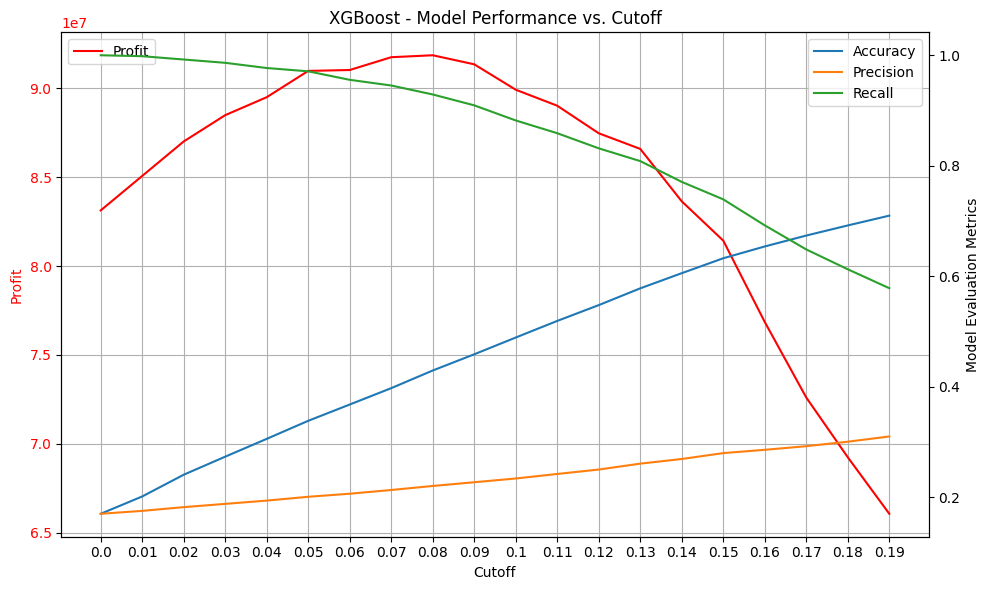

In [ ]:
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot the first field
ax1.plot(xgb_eval_df['Cutoff'], xgb_eval_df['Profit'], label='Profit', color='r')
ax1.set_xlabel('Cutoff')
ax1.set_ylabel('Profit', color='r')
ax1.tick_params(axis='y', labelcolor='r')
ax1.grid(True)

# Create a twin y-axis for the second field
ax2 = ax1.twinx()
ax2.plot(xgb_eval_df['Cutoff'], xgb_eval_df['Accuracy'], label='Accuracy')
ax2.plot(xgb_eval_df['Cutoff'], xgb_eval_df['Precision'], label='Precision')
ax2.plot(xgb_eval_df['Cutoff'], xgb_eval_df['Recall'], label='Recall')
ax2.set_ylabel('Model Evaluation Metrics')
ax2.tick_params(axis='y')

plt.xticks(ticks=xgb_eval_df['Cutoff'], labels=xgb_eval_df['Cutoff'], rotation=45)  # Rotate labels for better visibility if needed

# Add a title
plt.title('XGBoost - Model Performance vs. Cutoff')

# Add legends for both axes
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

plt.tight_layout()
plt.show()


## 3.6 Neural Network

In [ ]:

tf.random.set_seed(528)

# Define the model
model = keras.Sequential([
    layers.Dense(64, activation='tanh', input_shape=(X_train.shape[1],)),
    layers.Dropout(0.5),
    layers.Dense(32, activation='tanh'),
    layers.Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0005),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=100, batch_size=200, validation_split=0.2)


# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

Epoch 1/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.6273 - loss: 0.6668 - val_accuracy: 0.8418 - val_loss: 0.4646
Epoch 2/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8311 - loss: 0.4803 - val_accuracy: 0.8418 - val_loss: 0.4562
Epoch 3/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8315 - loss: 0.4702 - val_accuracy: 0.8418 - val_loss: 0.4506
Epoch 4/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8321 - loss: 0.4674 - val_accuracy: 0.8418 - val_loss: 0.4478
Epoch 5/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8323 - loss: 0.4648 - val_accuracy: 0.8418 - val_loss: 0.4476
Epoch 6/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8323 - loss: 0.4623 - val_accuracy: 0.8418 - val_loss: 0.4436
Epoch 7/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8323 - loss: 0.4581 - val_accuracy: 0.8418 - val_loss: 0.4397
Epoch 8/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8323 - loss: 0.4586 - val_accuracy: 0.8418 - v

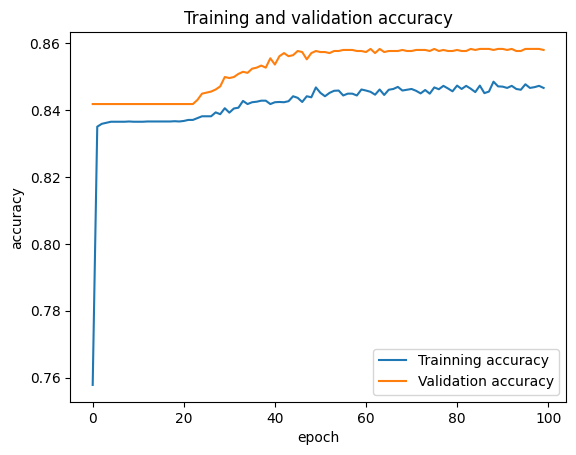

In [ ]:
# Access the training history
history_dict = history.history # Change this line to access the correct history

# plot the trainng and validation errors
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Trainning accuracy', 'Validation accuracy'], loc='lower right')
plt.show()

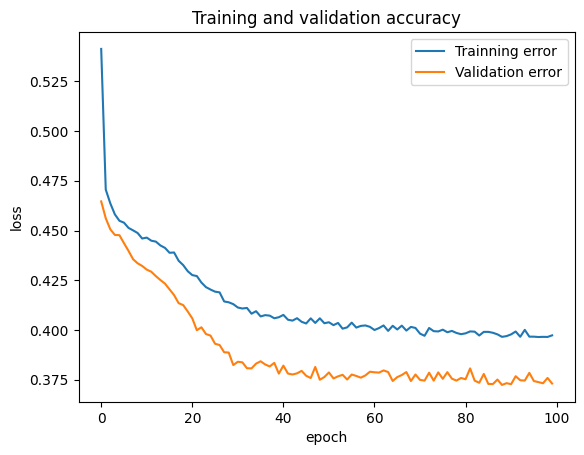

In [ ]:
# plot the trainng and validation errors
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Training and validation accuracy')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Trainning error', 'Validation error'], loc='upper right')
plt.show()

In [ ]:
# You can now use y_pred_prob with your prediction_evaluation function
nn_eval_df = prediction_evaluation(model, X_test, y_test, cut_offs=np.arange(0, 0.2, 0.01))

216/216 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


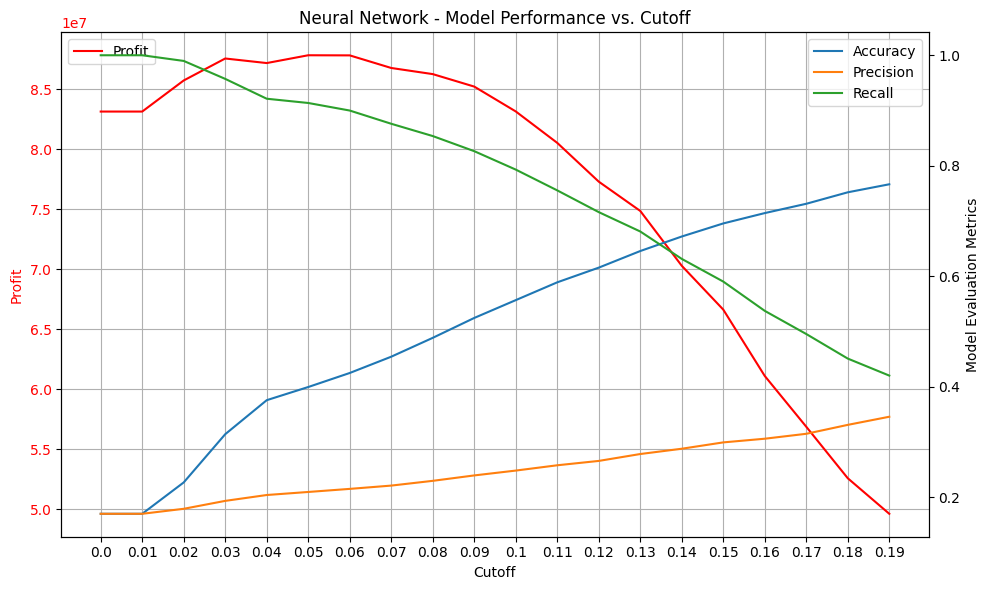

In [ ]:
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot the first field
ax1.plot(nn_eval_df['Cutoff'], nn_eval_df['Profit'], label='Profit', color='r')
ax1.set_xlabel('Cutoff')
ax1.set_ylabel('Profit', color='r')
ax1.tick_params(axis='y', labelcolor='r')
ax1.grid(True)

# Create a twin y-axis for the second field
ax2 = ax1.twinx()
ax2.plot(nn_eval_df['Cutoff'], nn_eval_df['Accuracy'], label='Accuracy')
ax2.plot(nn_eval_df['Cutoff'], nn_eval_df['Precision'], label='Precision')
ax2.plot(nn_eval_df['Cutoff'], nn_eval_df['Recall'], label='Recall')
ax2.set_ylabel('Model Evaluation Metrics')
ax2.tick_params(axis='y')

plt.xticks(ticks=nn_eval_df['Cutoff'], labels=nn_eval_df['Cutoff'], rotation=45)  # Rotate labels for better visibility if needed

# Add a title
plt.title('Neural Network - Model Performance vs. Cutoff')

# Add legends for both axes
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

plt.tight_layout()
plt.show()


In [ ]:
eval_dfs = [logreg_eval_df, dt_eval_df, rf_eval_df, bagging_eval_df, xgb_eval_df, nn_eval_df]

max_profit_rows = []
for i, eval_df in enumerate(eval_dfs):
  max_profit_index = eval_df['Profit'].idxmax()
  max_profit_row = eval_df.loc[[max_profit_index]]
  max_profit_rows.append(max_profit_row)

result_df = pd.concat(max_profit_rows)

In [ ]:
model = ['Logistic Regression', 'Decision Tree', 'Random Forest', 'Bagging', 'XGBoost', 'Neural Network']
result_df['Model'] = model

In [ ]:
result_df.reset_index(drop=True, inplace=True)

In [ ]:
result_df

,Cutoff,Accuracy,Precision,Recall,AUC_ROC,Confusion Matrix,Profit,Model
0,0.07,0.397008,0.209016,0.916168,0.719344,"[[1662, 4053], [98, 1071]]",87990000,Logistic Regression
1,0.00,0.169814,0.169814,1.000000,0.500000,"[[0, 5715], [0, 1169]]",83130000,Decision Tree
2,0.05,0.302876,0.192373,0.970915,0.711170,"[[950, 4765], [34, 1135]]",88550000,Random Forest
3,0.04,0.334544,0.197946,0.956373,0.698718,"[[1185, 4530], [51, 1118]]",88860000,Bagging
4,0.02,0.377833,0.205671,0.930710,0.704971,"[[1513, 4202], [81, 1088]]",88540000,XGBoost
5,0.05,0.399332,0.209330,0.913601,0.717736,"[[1681, 4034], [101, 1068]]",87820000,Neural Network


In [ ]:
result_df.to_csv('result_df.csv')

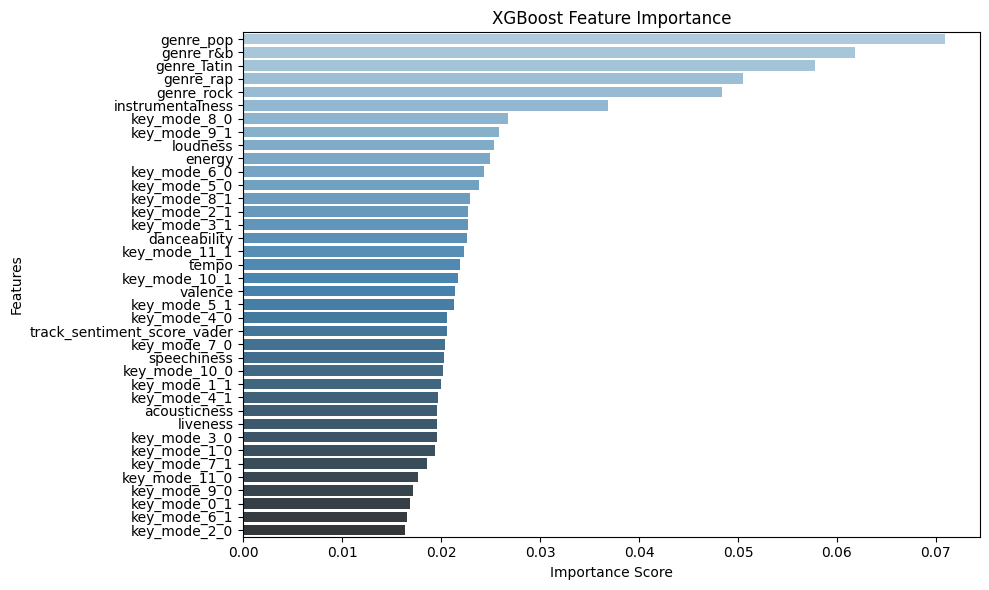

In [ ]:
# Assuming 'best_xgb_model' is your trained XGBoost model
xgb_feature_importances = best_xgb_model.feature_importances_

# Create a Pandas Series for better visualization
feature_importances = pd.Series(xgb_feature_importances, index=X.columns)
feature_importances_sorted = feature_importances.sort_values(ascending=False)

# Plot the feature importances
plt.figure(figsize=(10, 6))
sns.barplot(x=feature_importances_sorted.values, y=feature_importances_sorted.index, palette="Blues_d")  # Use a gradient blue color palette
plt.title('XGBoost Feature Importance')
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.tight_layout()
plt.show()

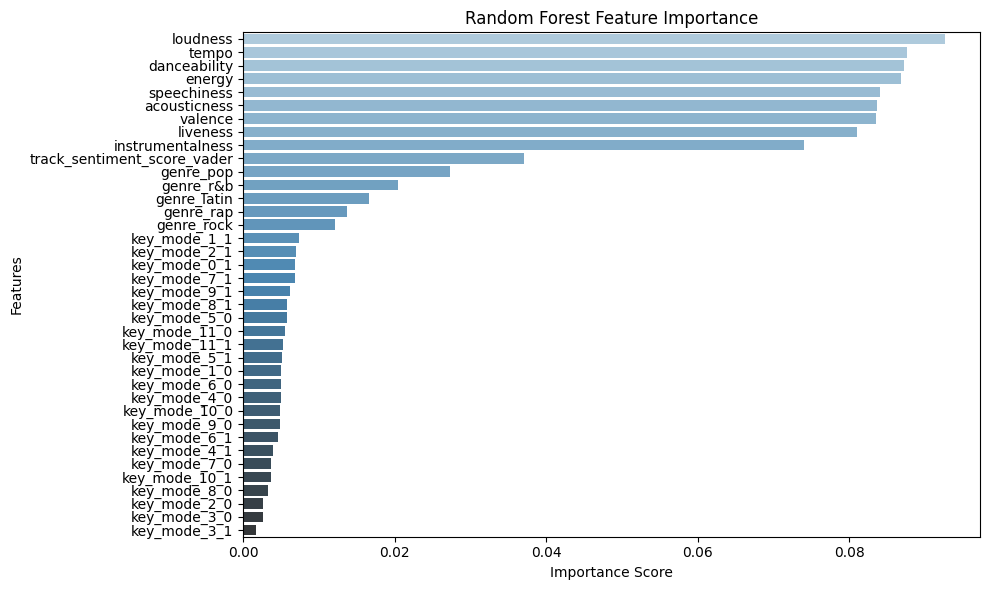

In [ ]:
# Get feature importances from the trained model
rf_feature_importances = best_rf_model.feature_importances_

# Create a Pandas Series for better visualization
feature_importances = pd.Series(rf_feature_importances, index=X.columns)
feature_importances_sorted = feature_importances.sort_values(ascending=False)

# Plot the feature importances using seaborn with a gradient blue color palette
plt.figure(figsize=(10, 6))
sns.barplot(x=feature_importances_sorted.values, y=feature_importances_sorted.index, palette="Blues_d")
plt.title('Random Forest Feature Importance')
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.tight_layout()
plt.show()

liveness                       0.091419
danceability                   0.091142
tempo                          0.088004
energy                         0.085788
valence                        0.085472
loudness                       0.084688
acousticness                   0.082660
speechiness                    0.079004
instrumentalness               0.072149
track_sentiment_score_vader    0.034046
genre_pop                      0.025843
genre_latin                    0.023310
genre_r&b                      0.018788
genre_rap                      0.017588
genre_rock                     0.013732
key_mode_6_0                   0.009852
key_mode_7_1                   0.007550
key_mode_9_1                   0.007357
key_mode_11_1                  0.006354
key_mode_1_0                   0.006074
key_mode_4_0                   0.005886
key_mode_5_0                   0.005819
key_mode_8_1                   0.005640
key_mode_5_1                   0.005519
key_mode_2_1                   0.005086


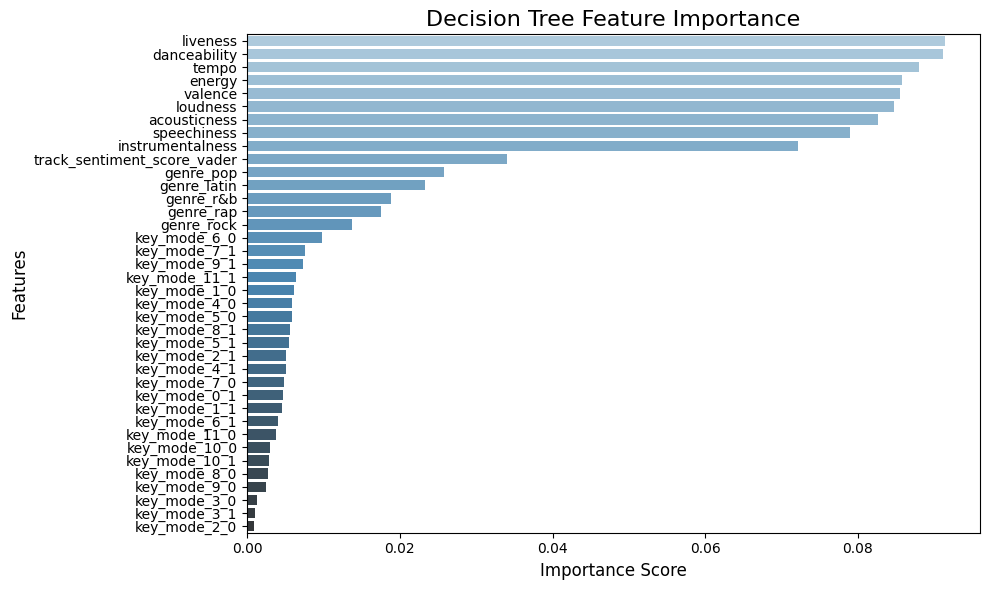

In [ ]:
feature_importances = pd.Series(tree_default.feature_importances_, index=X.columns)
feature_importances = feature_importances.sort_values(ascending=False)
print(feature_importances)

# Plotting with a gradient blue color palette
plt.figure(figsize=(10, 6))
sns.barplot(x=feature_importances.values, y=feature_importances.index, palette="Blues_d") # Use Blues_d for a gradient

plt.title('Decision Tree Feature Importance', fontsize=16)
plt.xlabel('Importance Score', fontsize=12)
plt.ylabel('Features', fontsize=12)
plt.tight_layout()
plt.show()
